In [1]:
# Import all needed libraries for this notebook
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import spearmanr

# Load numerical amino acid representations
representations = np.load('ube2i_single_point_mutants_25_13_38_22_full_rep.npz')
for key in representations.keys():
    print(f"Array '{key}' has shape: {representations[key].shape}")

# Extract 'id' and 'representation' arrays
id_array = representations['id']
representation_array = representations['representation']

Array 'id' has shape: (2854,)
Array 'sequence' has shape: (2854,)
Array 'representation' has shape: (2854, 158, 512)


In [2]:
# Reduce 512 LVs to 32 by PCA

# Flatten to a shape of (2854×158)×512 = (450932, 512)
reshaped_repr = representation_array.reshape(-1, 512)
reshaped_repr_df = pd.DataFrame(reshaped_repr)
reshaped_repr_df

# Skewness and kurtosis on standardised data
skewness = reshaped_repr_df.skew()
kurtosis = reshaped_repr_df.kurt()
repr_distribution_stats = pd.DataFrame({'skewness': skewness, 'kurtosis': kurtosis})
summary_stats_skew_kurt = repr_distribution_stats.describe().transpose()
print(summary_stats_skew_kurt)

# Standardize the data
scaler = StandardScaler()
reshaped_repr_scaled = scaler.fit_transform(reshaped_repr)

# Apply PCA to reduce from 512 to 32 dimensions
pca = PCA(n_components=32)
reduced_repr = pca.fit_transform(reshaped_repr_scaled)

# Reshape back to (2854, 158, 32)
reduced_repr = reduced_repr.reshape(2854, 158, 32)

# Flatten to 158x16=2528 variables (to 2D)
reduced_repr_flat = reduced_repr.reshape(reduced_repr.shape[0], -1)
reduced_repr_flat.shape

# Convert 'id' array and flattened 'representation' array to DFs and concatenate
id_df = pd.DataFrame(id_array, columns=['id'])

# Decode byte strings to regular strings and remove "b" and "'" from the 'id' column
id_df['id'] = id_df['id'].apply(lambda x: x.decode('utf-8'))
remove_symbols = "b'"
id_df['id'] = id_df['id'].str.replace(f"[{remove_symbols}]", " ", regex=True)

# Concatenate with id_df
reduced_repr_flat_df = pd.DataFrame(reduced_repr_flat)
reduced_repr_flat_df = pd.concat([id_df, reduced_repr_flat_df], axis=1)
reduced_repr_flat_df.columns = reduced_repr_flat_df.columns.astype(str)

# Split mutant ID and fitness scores into two new columns
reduced_repr_flat_df[['mut_id', 'fitness']] = reduced_repr_flat_df['id'].str.split(':', expand=True)
reduced_repr_flat_df = reduced_repr_flat_df[['id', 'mut_id', 'fitness'] + [col for col in reduced_repr_flat_df.columns if col not in ['id', 'mut_id', 'fitness']]]
reduced_repr_flat_df['fitness'] = pd.to_numeric(reduced_repr_flat_df['fitness'])

# Bin fitness scores into quantiles
quantile_no = 8
reduced_repr_flat_df['fitness_group'], bins = pd.qcut(reduced_repr_flat_df['fitness'], q=quantile_no, labels=False, retbins=True)

# Print bin edges
print("Bin edges (boundaries):", bins)

# Save reduced representations to a csv
reduced_repr_flat_df.to_csv('reduced_repr32_flat_df.csv', index=False)

          count      mean       std       min       25%       50%       75%  \
skewness  512.0 -0.020470  0.313289 -1.311813 -0.193928 -0.014168  0.158576   
kurtosis  512.0 -0.114606  0.499120 -0.869325 -0.443297 -0.190232  0.075426   

               max  
skewness  1.241845  
kurtosis  3.069290  
Bin edges (boundaries): [0.         0.34742916 0.41501102 0.49650659 0.62802055 0.77240558
 0.9084807  1.10469232 4.10751009]


In [3]:
reduced_repr_flat_df

,id,mut_id,fitness,0,1,2,3,4,5,6,...,5047,5048,5049,5050,5051,5052,5053,5054,5055,fitness_group
0,K30D:0.5080366134643555,K30D,0.508037,-2.570003,4.022203,-2.825403,-0.497435,5.511098,1.808109,-3.421183,...,4.090080,2.588068,-0.768769,-2.247591,0.837915,1.717101,-1.388294,3.588889,-0.931026,3
1,D127S:0.619499683380127,D127S,0.619500,-2.408313,4.189716,-3.005158,-0.643381,5.679404,1.771026,-3.547469,...,3.892934,2.406613,-0.614024,-2.283392,0.825378,1.663443,-1.421210,3.576710,-1.085286,3
2,L114Y:0.9718983173370361,L114Y,0.971898,-2.414788,4.207225,-2.947061,-0.760829,5.583824,1.845514,-3.586225,...,4.015271,2.562612,-0.828377,-2.202740,0.825129,1.706036,-1.425214,3.617202,-0.911270,6
3,H83F:0.5161952972412109,H83F,0.516195,-2.336842,4.166052,-2.990552,-0.765807,5.636672,1.816508,-3.394135,...,4.005070,2.581034,-0.789591,-2.170589,0.830986,1.640153,-1.550851,3.589580,-0.909703,3
4,R61G:0.7325457334518433,R61G,0.732546,-2.350058,4.131976,-3.005839,-0.800218,5.611013,1.724892,-3.542427,...,4.027220,2.556448,-0.758970,-2.160232,0.863695,1.664389,-1.502655,3.552477,-0.879521,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2849,A15W:0.6964787244796753,A15W,0.696479,-2.367344,4.253077,-3.006349,-0.796674,5.611206,1.773938,-3.572023,...,4.013757,2.517343,-0.709147,-2.205670,0.852601,1.681695,-1.429059,3.589870,-0.963148,4
2850,P28F:0.5048689246177673,P28F,0.504869,-2.355089,4.190887,-2.925232,-0.709169,5.654644,1.774303,-3.631063,...,4.042241,2.542823,-0.745758,-2.224992,0.777835,1.723508,-1.420063,3.594591,-0.913978,3
2851,I112Y:0.28946661949157715,I112Y,0.289467,-2.360195,4.133191,-2.966794,-0.757661,5.583155,1.817814,-3.496653,...,4.040194,2.562587,-0.758786,-2.202947,0.834370,1.688931,-1.411974,3.607146,-0.931543,0
2852,P32W:0.9419150352478027,P32W,0.941915,-2.400716,4.281382,-2.914210,-0.778232,5.618531,1.781330,-3.476890,...,3.992557,2.485556,-0.759216,-2.235439,0.838785,1.698729,-1.476900,3.571578,-0.958445,6


In [4]:
# Ridge regression on square and MinMax scaled reduced and flattened aa representations
X = reduced_repr_flat_df.drop(columns=['mut_id', 'fitness', 'id', 'fitness_group']) #Still contains 'id' and 'fitness_group'columns
y = reduced_repr_flat_df['fitness']

# Polynomial scaling (squaring)
X_squared = pd.DataFrame()

squared_features = {f'{col}_squared': X[col] ** 2 for col in X.columns}
X_squared = pd.concat([X_squared, pd.DataFrame(squared_features)], axis=1)

# MinMax Scaling
minmaxscaler = MinMaxScaler()
X_squared_minmax = minmaxscaler.fit_transform(X_squared)
#X_squared_scaled = scaler.fit_transform(X2_squared) # worse by 0.06 (spearman)

# Sample 96 samples, in a stratified manner, based on fitness_group
X_train, X_test, y_train, y_test = train_test_split(X_squared_minmax, y, train_size=96, stratify=reduced_repr_flat_df['fitness_group'], random_state=42)

# Define a range of alphas for cross-validation
alphas = np.logspace(-6, 6, 13)  
ridge_cv = RidgeCV(alphas=alphas, store_cv_values=True)
ridge_cv.fit(X_train, y_train)

# Predict the fitness for the test set
y_pred_ridge = ridge_cv.predict(X_test)

# Print the best alpha and model performance
print(f"Best alpha: {ridge_cv.alpha_}")
print(f"Training Score: {ridge_cv.score(X_train, y_train)}")
print(f"Test Score: {ridge_cv.score(X_test, y_test)}")

# Predict and evaluate the model
mse = mean_squared_error(y_test, y_pred_ridge)
print(f"Mean Squared Error: {mse}")
r2 = r2_score(y_test, y_pred_ridge)
print(f"R2 score: {r2}")
mae = mean_absolute_error(y_test, y_pred_ridge)
print(f"Mean Absolute Error: {mae}")
# Spearman's correl
spearman_corr, spearman_p_value = spearmanr(y_test, y_pred_ridge)
print(f"Spearman's correlation: {spearman_corr}")
print(f"Spearman's p-value: {spearman_p_value}")

Best alpha: 10.0
Training Score: 0.6805002647181085
Test Score: 0.13499545046570283
Mean Squared Error: 0.1090602650573777
R2 score: 0.13499545046570283
Mean Absolute Error: 0.25703529050919155
Spearman's correlation: 0.4241251911554536
Spearman's p-value: 7.49936012159142e-121


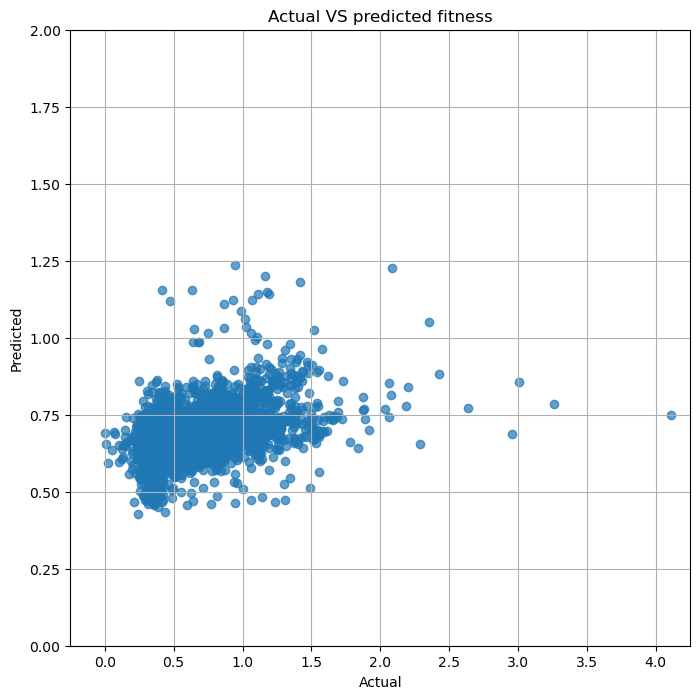

In [5]:
# Plot actual fitness against predicted fitness
plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred_ridge, alpha=0.7)
plt.xlim(-0.25, 4.25)
plt.ylim(0, 2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual VS predicted fitness')
plt.grid(True)
plt.show()

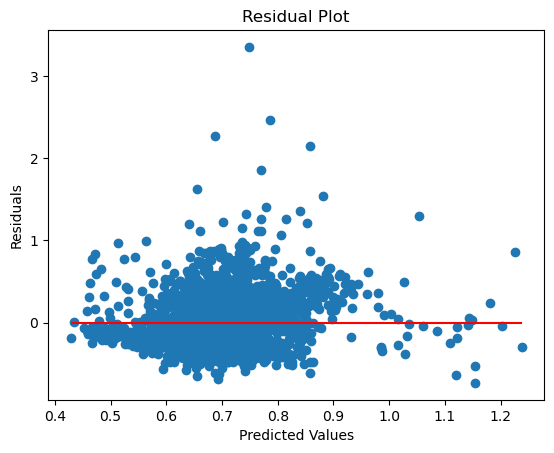

In [6]:
# Plot residuals
residuals = y_test - y_pred_ridge

# Plot residuals
plt.scatter(y_pred_ridge, residuals)
plt.hlines(0, xmin=min(y_pred_ridge), xmax=max(y_pred_ridge), colors='r')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

In [7]:
# RFR 

# Use train_test_split with the stratify parameter
X_train, X_test, y_train, y_test = train_test_split(X_squared, y, train_size=96, stratify=reduced_repr_flat_df['fitness_group'], random_state=42)

# Train the rfr
rfr = RandomForestRegressor(random_state=42)
rfr.fit(X_train, y_train)

# Predict the fitness scores for the test set
y_pred = rfr.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
r2 = r2_score(y_test, y_pred)
print(f"R2 score: {r2}")
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error: {mae}")

# Spearman's correl
spearman_corr, spearman_p_value = spearmanr(y_test, y_pred)
print(f"Spearman's correlation: {spearman_corr}")
print(f"Spearman's p-value: {spearman_p_value}")

Mean Squared Error: 0.11417599396282901
R2 score: 0.09442037231903422
Mean Absolute Error: 0.266276173929355
Spearman's correlation: 0.31780437397611855
Spearman's p-value: 9.105814228532397e-66
